**ALGORITHM: DeepAR**

---




# Preparation



> ***Import Libraries***







In [ ]:
!pip install gluonts
!pip install mxnet
!pip install gluonts.model.deepar

!pip install --upgrade mxnet==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement gluonts.model.deepar (from versions: none)
ERROR: No matching distribution found for gluonts.model.deepar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.model_selection import train_test_split

from gluonts.dataset.common import ListDataset
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.field_names import FieldName

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

# Descriptive Statistical



> ***Data Loading***



In [ ]:
df = pd.read_csv("/content/XOM.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100
...,...,...,...,...,...,...,...
1332,2023-04-19,116.080002,116.900002,115.769997,116.570000,116.570000,10682600
1333,2023-04-20,115.129997,115.680000,113.230003,115.639999,115.639999,17038700
1334,2023-04-21,116.489998,116.879997,115.260002,116.010002,116.010002,14313800
1335,2023-04-24,115.919998,118.889999,115.879997,118.199997,118.199997,15831300


In [ ]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100
5,2018-01-09,86.940002,87.150002,86.650002,86.769997,66.207489,8131600
6,2018-01-10,87.000000,87.190002,85.980003,86.080002,65.681007,10822300
7,2018-01-11,86.360001,87.370003,85.930000,86.930000,66.329590,14366000
8,2018-01-12,87.199997,87.989998,87.180000,87.519997,66.779762,9834500
9,2018-01-16,87.739998,87.760002,86.599998,86.970001,66.360107,10882800




> ***Descriptive Statistical***





> ***Detail Statistical***



In [ ]:
df_drop_date=df.drop('Date', axis=1)
detail_statistical= df_drop_date.describe()
detail_statistical


,Open,High,Low,Close,Adj Close,Volume
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03
mean,71.965453,72.775034,71.162521,71.981159,63.709470,2.044246e+07
std,20.246180,20.429780,20.118105,20.321002,21.213097,1.081068e+07
min,31.410000,32.380001,30.110001,31.450001,26.564503,3.979400e+06
25%,58.009998,58.880001,57.320000,58.200001,52.986561,1.278670e+07
50%,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07
75%,82.730003,83.309998,82.000000,82.690002,67.428345,2.551770e+07
max,117.720001,119.629997,116.160004,119.169998,118.260002,8.443940e+07


In [ ]:
mode_dict = {}
median_dict ={}
variance_dict = {}

for column in df_drop_date.columns:
    mode_dict[column] = df_drop_date[column].mode()[0]
    median_dict[column] = df_drop_date[column].median()
    variance_dict[column] = df_drop_date[column].var()

# Convert the mode_dict to a DataFrame and transpose it
mode_df = pd.DataFrame.from_dict(mode_dict, orient='index', columns=['mode']).transpose()
median_df = pd.DataFrame.from_dict(median_dict, orient='index', columns=['median']).transpose()
variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance']).transpose()

cv_df = pd.DataFrame(df_drop_date.apply(lambda x: np.std(x) / np.mean(x)).rename('CV')).T
kurtosis_df = pd.DataFrame(df_drop_date.apply(lambda x: kurtosis(x)).rename('Kurtosis')).T
skew_df = pd.DataFrame(df_drop_date.apply(lambda x: skew(x)).rename('Skewness')).T


In [ ]:
detail_statistical = pd.concat([detail_statistical, mode_df], axis=0)
detail_statistical = pd.concat([detail_statistical, median_df], axis=0)
detail_statistical = pd.concat([detail_statistical, variance_df], axis=0)
detail_statistical = pd.concat([detail_statistical, cv_df], axis=0)
detail_statistical = pd.concat([detail_statistical, kurtosis_df], axis=0)

detail_statistical

,Open,High,Low,Close,Adj Close,Volume
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03
mean,71.965453,72.775034,71.162521,71.981159,63.709470,2.044246e+07
std,20.246180,20.429780,20.118105,20.321002,21.213097,1.081068e+07
min,31.410000,32.380001,30.110001,31.450001,26.564503,3.979400e+06
25%,58.009998,58.880001,57.320000,58.200001,52.986561,1.278670e+07
50%,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07
75%,82.730003,83.309998,82.000000,82.690002,67.428345,2.551770e+07
max,117.720001,119.629997,116.160004,119.169998,118.260002,8.443940e+07
mode,80.809998,80.260002,82.559998,60.930000,57.711708,1.104760e+07
median,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07






> ***Visualization***





In [ ]:
columns= df_drop_date.columns
columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

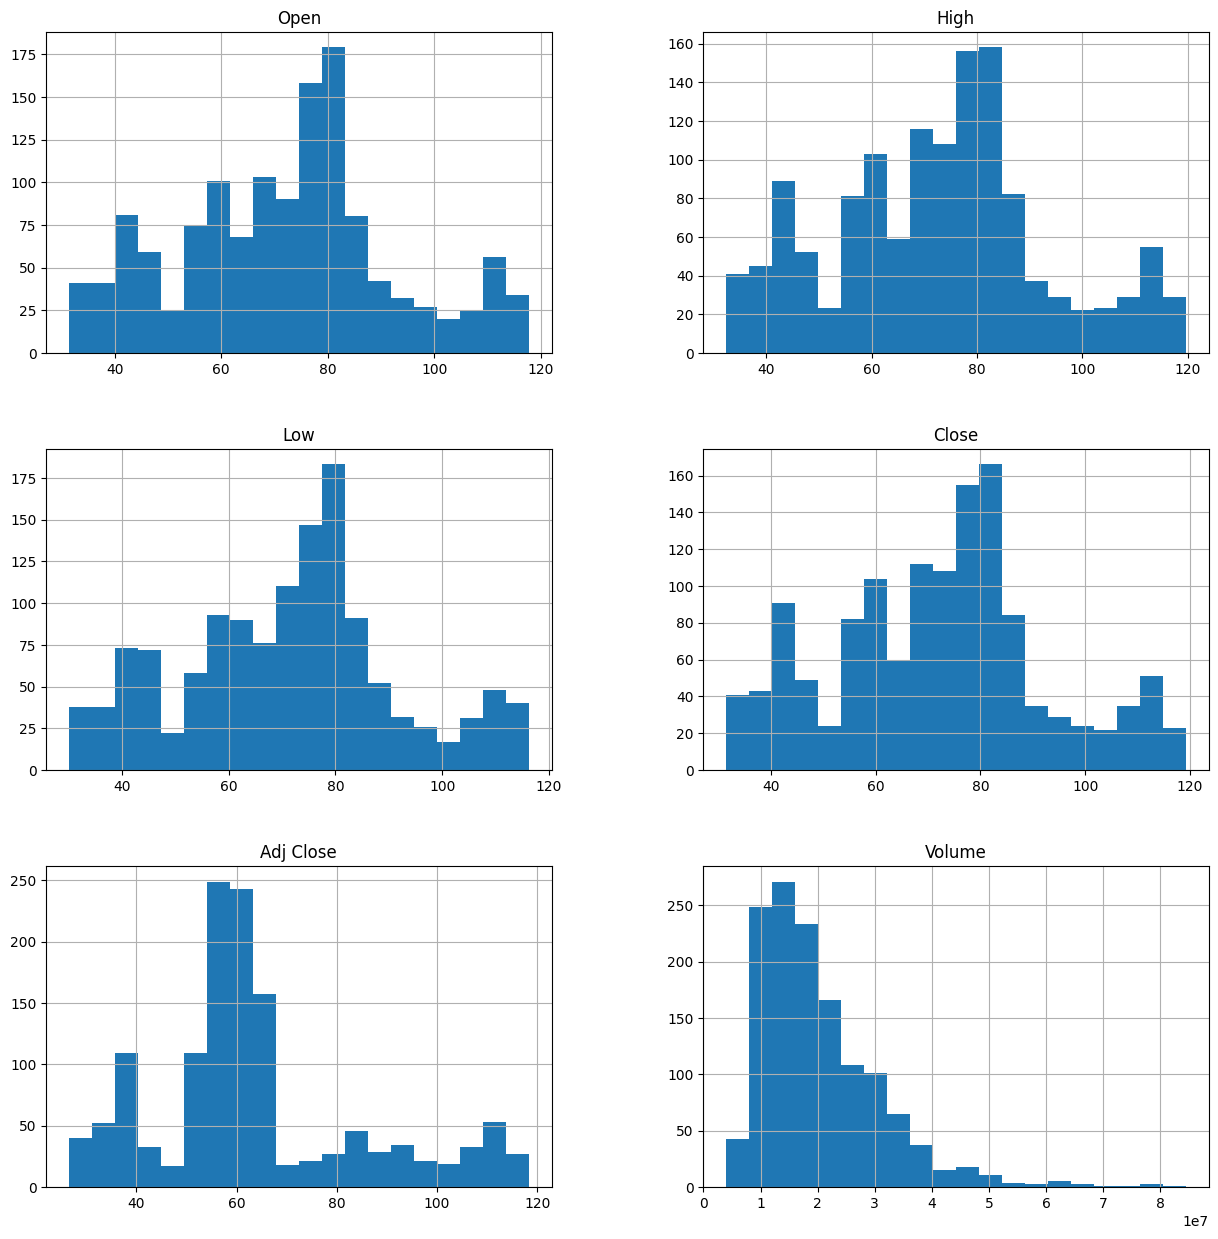

In [ ]:
df_drop_date[df_drop_date.columns].hist(figsize=(15,15), bins=20)

In [ ]:
data = pd.read_csv("/content/XOM.csv")
def descriptive_summary(column):
    fig, axs = plt.subplots(1,2, figsize=(19,6))
    axs[0].hist(data[column]) #creating histogram plot
    axs[0].axvline(data[column].mean(), color='red', label=f"Mean: {round(data[column].mean(),2)}") #vertical line for mean of the distribution
    axs[0].axvline(data[column].median(), color='green', label=f"Median: {round(data[column].median(),2)}") #vertical line for median of the distribution
    axs[0].axvline(x=data[column].describe()[4],color='r', linestyle='--', label=f"25th percentile: {data[column].describe()[4]}") #vertical line for 25th percentile of the distribution
    axs[0].axvline(x=data[column].describe()[6],color='r', linestyle='--', label=f"75th percentile: {data[column].describe()[6]}") #vertical line for 75th percentile of the distribution
    axs[0].legend()
    sns.boxplot(data=data, x=column, ax=axs[1]) #creating boxplot
    axs[1].axvline(data[column].mean(), color='red') #vertical line for the mean of the distribution
    fig.suptitle(f"Histogram and Boxplot of {column}")
    plt.show()
    print(f"{data[column].describe().round(3)}\n")
    print(f"Range: {data[column].max() - data[column].min()}")
    print(f"Interquartile Range: {data[column].describe()[6] - data[column].describe()[4]}\n")
    print(f"Skewness: {skew(data[data[column].isna()==False][column], bias=True)}")
    print(f"Kurtosis: {kurtosis(data[data[column].isna()==False][column], bias=True)}")

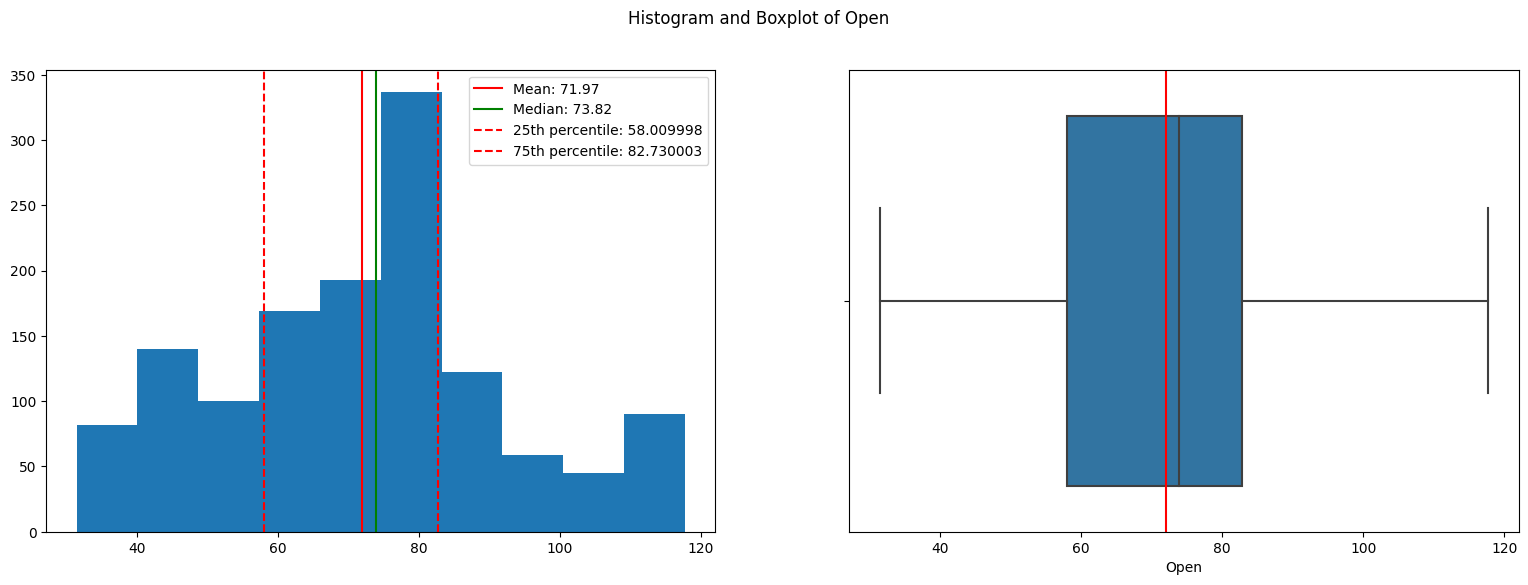

count    1337.000
mean       71.965
std        20.246
min        31.410
25%        58.010
50%        73.820
75%        82.730
max       117.720
Name: Open, dtype: float64

Range: 86.310001
Interquartile Range: 24.720004999999993

Skewness: 0.12225086808394776
Kurtosis: -0.4188869438570588


In [ ]:
descriptive_summary(columns[0])

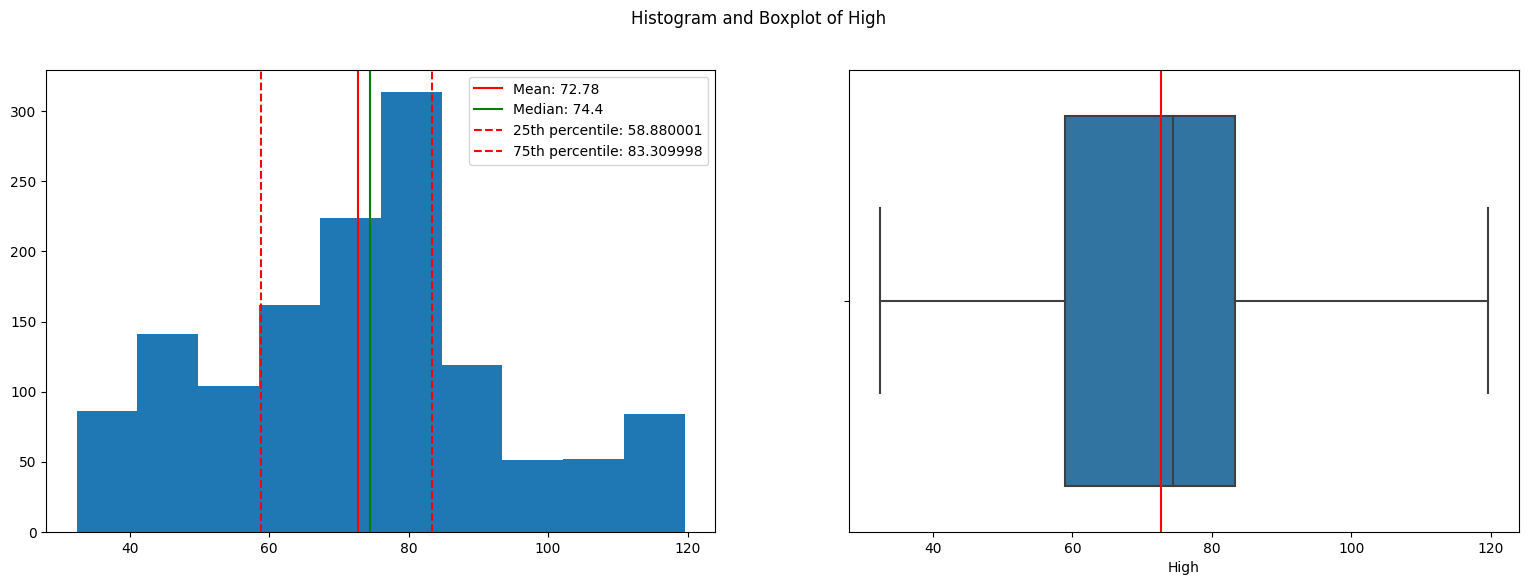

count    1337.000
mean       72.775
std        20.430
min        32.380
25%        58.880
50%        74.400
75%        83.310
max       119.630
Name: High, dtype: float64

Range: 87.24999600000001
Interquartile Range: 24.429996999999993

Skewness: 0.15014697627630247
Kurtosis: -0.4173526920772699


In [ ]:
descriptive_summary(columns[1])

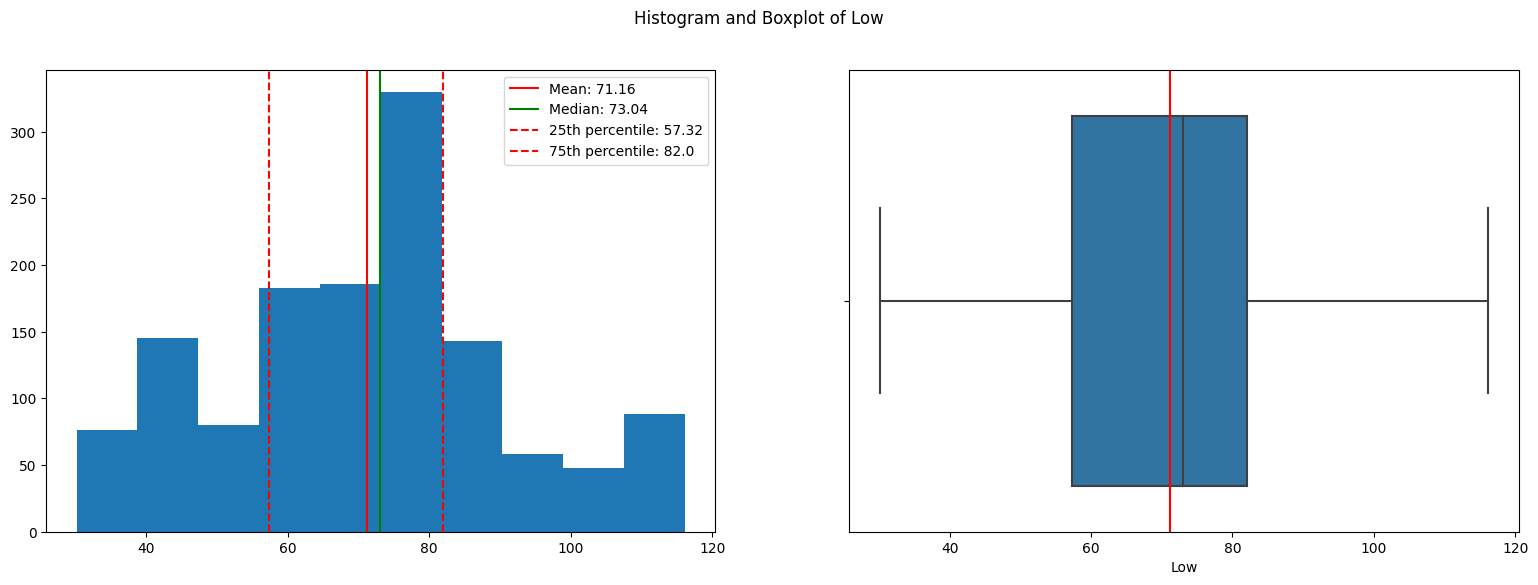

count    1337.000
mean       71.163
std        20.118
min        30.110
25%        57.320
50%        73.040
75%        82.000
max       116.160
Name: Low, dtype: float64

Range: 86.050003
Interquartile Range: 24.68

Skewness: 0.09910848313670854
Kurtosis: -0.4227718870682571


In [ ]:
descriptive_summary(columns[2])

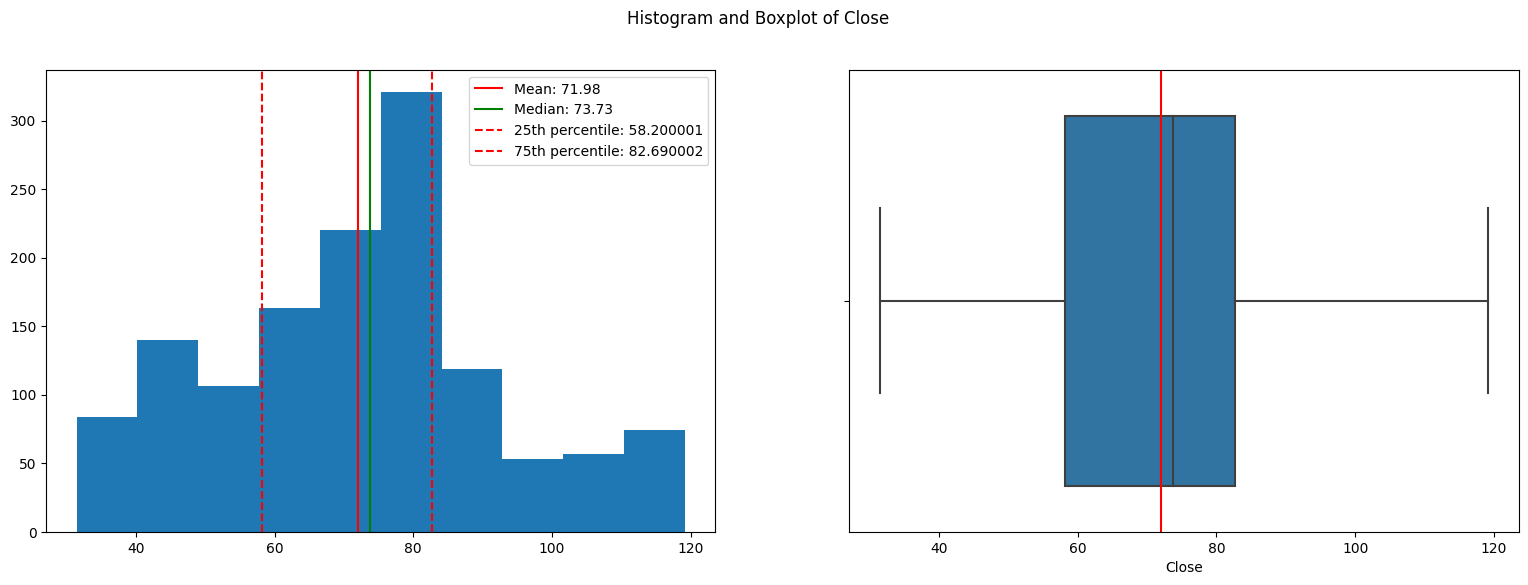

count    1337.000
mean       71.981
std        20.321
min        31.450
25%        58.200
50%        73.730
75%        82.690
max       119.170
Name: Close, dtype: float64

Range: 87.719997
Interquartile Range: 24.490001000000007

Skewness: 0.12768236457993015
Kurtosis: -0.416871903223218


In [ ]:
descriptive_summary(columns[3])

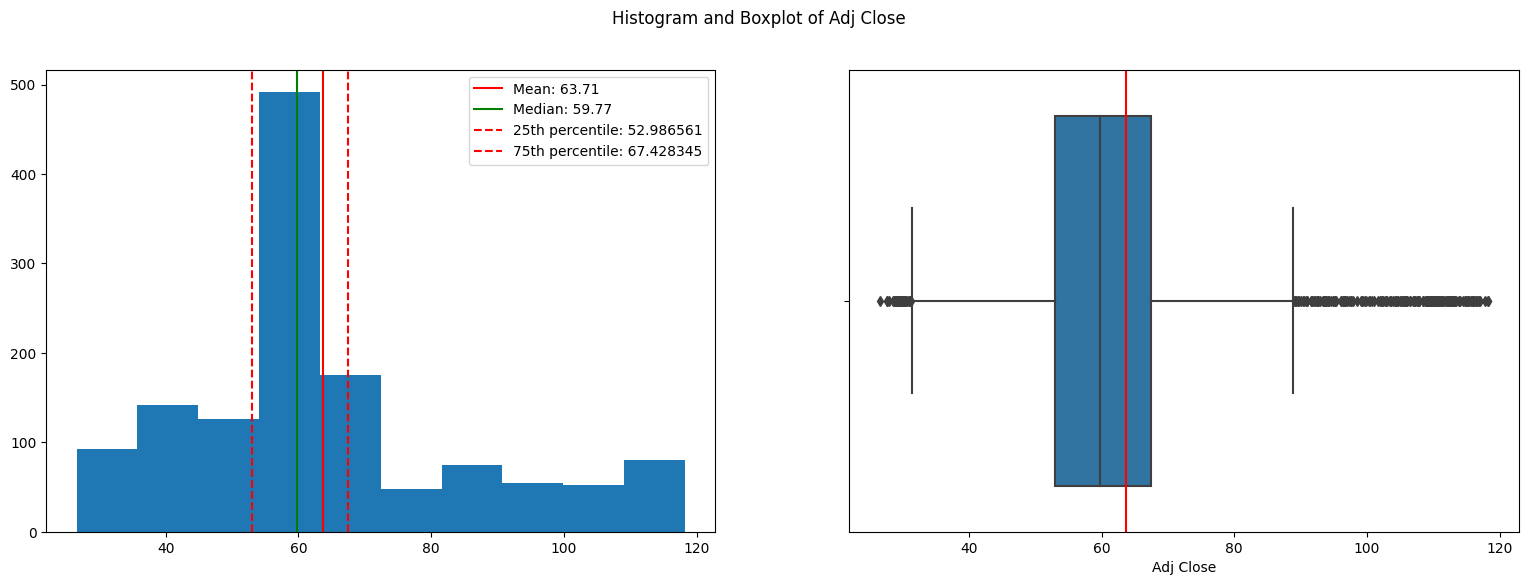

count    1337.000
mean       63.709
std        21.213
min        26.565
25%        52.987
50%        59.767
75%        67.428
max       118.260
Name: Adj Close, dtype: float64

Range: 91.695499
Interquartile Range: 14.441783999999991

Skewness: 0.8079885737038286
Kurtosis: 0.19365326421185358


In [ ]:
descriptive_summary(columns[4])

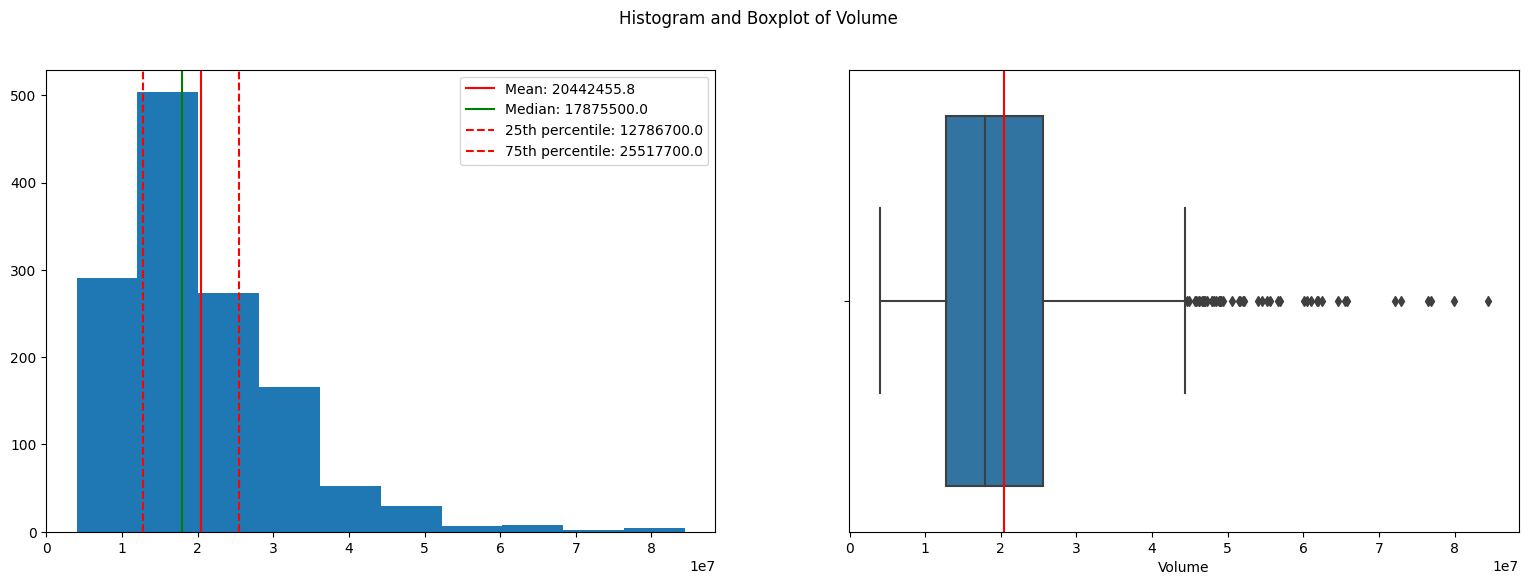

count    1.337000e+03
mean     2.044246e+07
std      1.081068e+07
min      3.979400e+06
25%      1.278670e+07
50%      1.787550e+07
75%      2.551770e+07
max      8.443940e+07
Name: Volume, dtype: float64

Range: 80460000
Interquartile Range: 12731000.0

Skewness: 1.6755512763350935
Kurtosis: 4.340815798165391


In [ ]:
descriptive_summary(columns[5])

# Experiment: XOM 7-2-1



> ***Devide train/test/validate 7/2/1***

In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
val_data
# #train: 935
# #test 267
# #val: 135

,Date,Open,High,Low,Close,Adj Close,Volume
1202,2022-10-11,97.220001,99.760002,96.750000,98.000000,96.475006,17804100
1203,2022-10-12,97.500000,98.910004,97.230003,98.430000,96.898323,12635800
1204,2022-10-13,97.550003,102.449997,97.400002,101.870003,100.284790,22019100
1205,2022-10-14,101.120003,102.239998,99.040001,99.190002,97.646492,15222000
1206,2022-10-17,101.070000,101.970001,100.500000,100.620003,99.054245,14283200
...,...,...,...,...,...,...,...
1332,2023-04-19,116.080002,116.900002,115.769997,116.570000,116.570000,10682600
1333,2023-04-20,115.129997,115.680000,113.230003,115.639999,115.639999,17038700
1334,2023-04-21,116.489998,116.879997,115.260002,116.010002,116.010002,14313800
1335,2023-04-24,115.919998,118.889999,115.879997,118.199997,118.199997,15831300




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
# testing_data  = [{"start": pd.Timestamp(df['Date'][int(0.7*len(df))]), "target": df['Close'][int(0.7*len(df)):int(0.9*len(df))]}]
# testing_data  = [{"start": pd.Timestamp(df['Date'][len(df) - train_size - test_size]), "target": df['Close'][len(df) - train_size - test_size]}]

train_ds = ListDataset(training_data, freq='1D')
# val_ds = ListDataset(valing_data, freq='1D')
# test_ds = ListDataset(testing_data, freq='1D')
test_ds


[{'start': Period('2021-09-20', 'D'),
  'target': array([ 94.78,  94.85,  97.64, 100.06, 100.6 , 102.97, 103.36, 103.33,
         101.45, 104.33, 104.72, 105.86, 104.93, 105.68, 108.05, 107.13,
         107.15, 107.79, 108.81, 109.61, 109.56, 111.7 , 113.16, 111.74,
         112.8 , 113.85, 114.1 , 112.07, 113.12, 114.49, 114.53, 113.83,
         113.01, 113.51, 114.74, 115.15, 116.  , 114.15, 114.16, 114.23,
         116.82, 117.28, 115.42, 114.45, 111.91, 113.91, 116.3 , 117.19,
         114.51, 114.85, 112.87, 112.1 , 115.14, 114.41, 116.2 , 117.92,
         118.45, 118.14, 118.34, 115.88, 116.22, 115.56, 116.64, 113.6 ,
         113.65, 115.47, 116.13, 116.41, 118.79, 118.56, 117.95, 117.43,
         117.35, 119.26, 121.43, 122.22, 123.26, 125.03, 125.11, 127.97,
         127.33, 126.8 , 128.96, 129.38, 128.91, 128.45, 126.91, 127.18,
         132.59, 132.69, 135.37, 130.61, 131.33, 134.79, 135.41, 134.2 ,
         135.88, 138.55, 136.44, 137.79, 136.04, 138.81, 136.67, 134.26,
   



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=402,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:22<00:00,  2.22it/s, epoch=50/50, avg_epoch_loss=1.48]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

135

In [ ]:
yval=val_data.Close.tolist()
len(yval)


135

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 49.45329753453728
Testing RMSE: 29.759680857654583
Validation MAPE: 44.655466644941825
Testing MAPE: 32.01806333377121
Validation MDA: 51.49253731343284
Testing MDA: 48.87218045112782




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 402 days: [54.298458099365234, 53.94416046142578, 54.12992858886719, 53.99478530883789, 53.39679718017578, 52.705352783203125, 52.3453254699707, 51.17509460449219, 50.04869079589844, 50.1788330078125, 50.159847259521484, 49.8720817565918, 49.529930114746094, 49.881813049316406, 50.138633728027344, 50.52521896362305, 51.29109191894531, 51.993309020996094, 52.3059196472168, 52.288108825683594, 52.253517150878906, 51.998287200927734, 51.62567901611328, 52.048099517822266, 51.73261642456055, 51.266136169433594, 50.636497497558594, 50.22115707397461, 49.91983413696289, 50.077842712402344, 50.47316360473633, 50.79059600830078, 50.934696197509766, 50.8826789855957, 51.17105484008789, 51.48198699951172, 51.950740814208984, 52.742008209228516, 53.15510559082031, 53.08576583862305, 53.1346549987793, 53.04991149902344, 53.12520980834961, 53.08660125732422, 53.550113677978516, 53.833133697509766, 53.90080642700195, 53.525726318359375, 53.49239730834961, 53.32561111450195, 53.



> Visualization



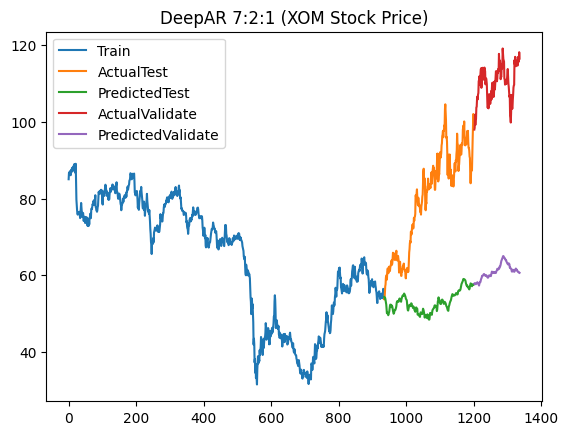

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 7:2:1 (XOM Stock Price)')
plt.show()

# Experiment: XOM 6-2-2



> ***Devide train/test/validate 6/2/2***

In [ ]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
train_data
# #train: 802
# #test 267
# #val: 268

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100
...,...,...,...,...,...,...,...
797,2021-03-04,57.119999,59.470001,57.099998,58.709999,53.688900,52137500
798,2021-03-05,59.830002,61.049999,59.110001,60.930000,55.719028,51429800
799,2021-03-08,61.580002,61.610001,59.820000,60.869999,55.664162,38154600
800,2021-03-09,60.610001,61.389999,59.470001,59.930000,54.804565,35645900




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
train_ds = ListDataset(training_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([85.03, 86.7 , 86.82, 86.75, 87.14, 86.77, 86.08, 86.93, 87.52,
         86.97, 88.  , 87.43, 87.15, 88.25, 88.3 , 88.53, 88.37, 89.  ,
         88.01, 86.78, 87.3 , 89.07, 84.53, 79.72, 78.35, 76.94, 76.07,
         75.78, 76.42, 76.3 , 76.46, 76.21, 76.54, 75.75, 74.89, 75.86,
         77.53, 78.84, 77.5 , 75.74, 75.2 , 75.55, 76.27, 76.18, 74.26,
         74.12, 74.56, 75.24, 74.53, 73.6 , 74.42, 75.12, 74.15, 73.99,
         75.04, 73.5 , 72.89, 74.  , 73.7 , 72.81, 74.61, 73.22, 75.02,
         74.87, 76.02, 74.87, 74.87, 77.07, 77.43, 77.22, 77.84, 78.54,
         78.33, 79.22, 79.42, 79.  , 79.57, 78.35, 79.5 , 80.86, 77.79,
         77.75, 76.95, 76.8 , 76.54, 76.9 , 77.74, 78.09, 79.93, 81.72,
         81.28, 81.83, 81.79, 82.02, 81.88, 81.3 , 82.28, 81.64, 82.15,
         80.27, 78.71, 78.42, 81.5 , 81.24, 81.83, 80.97, 80.68, 82.06,
         82.88, 83.6 , 83.1 , 82.42, 81.51, 81.89, 80.66, 80.82, 80.7 ,
         80.45, 



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=535,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:28<00:00,  1.73it/s, epoch=50/50, avg_epoch_loss=1.46]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

268

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267

In [ ]:
yval=val_data.Close.tolist()
len(yval)


268



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 58.1258608209783
Testing RMSE: 24.01944262255553
Validation MAPE: 56.444988059952465
Testing MAPE: 32.05865171023305
Validation MDA: 53.93258426966292
Testing MDA: 51.50375939849624




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 535 days: [53.105228424072266, 52.488746643066406, 52.59109878540039, 52.403438568115234, 52.085975646972656, 51.693660736083984, 51.131832122802734, 49.62397384643555, 48.290218353271484, 48.212913513183594, 47.475345611572266, 46.438575744628906, 45.63169479370117, 45.02947235107422, 44.71241760253906, 44.07491683959961, 44.806678771972656, 45.07229995727539, 44.6591682434082, 43.92513656616211, 43.72079086303711, 43.338218688964844, 43.184532165527344, 44.2423095703125, 44.31196212768555, 44.1746711730957, 43.664756774902344, 43.428733825683594, 43.31745147705078, 43.403770446777344, 44.449615478515625, 44.731475830078125, 44.78482437133789, 44.645782470703125, 44.682342529296875, 44.63394546508789, 44.73664855957031, 45.753631591796875, 44.85402297973633, 44.170494079589844, 44.32376480102539, 44.384796142578125, 44.479652404785156, 44.5373420715332, 45.534149169921875, 45.58745574951172, 45.460472106933594, 45.4874153137207, 45.31629943847656, 45.021625518798



> Visualization



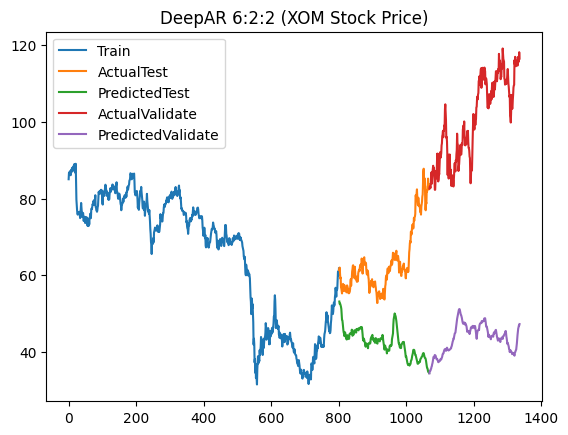

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 6:2:2 (XOM Stock Price)')
plt.show()

# Experiment: CVX 7-2-1

In [ ]:
df = pd.read_csv("/content/CVX.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,100.577354,5626000
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,101.310501,5805500
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,100.995163,4598300
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,100.829620,4189200
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,101.326271,4826100
...,...,...,...,...,...,...,...
1332,2023-04-19,169.460007,170.740005,169.100006,170.679993,169.024826,5506800
1333,2023-04-20,168.759995,170.059998,168.020004,169.850006,168.202881,5851100
1334,2023-04-21,169.830002,170.589996,168.839996,169.119995,167.479950,7179000
1335,2023-04-24,169.100006,172.380005,168.580002,171.479996,169.817062,7177600




> ***Devide train/test/validate 7/2/1***

In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
val_data
# #train: 935
# #test 267
# #val: 135

,Date,Open,High,Low,Close,Adj Close,Volume
1202,2022-10-11,154.750000,159.929993,154.110001,157.169998,153.097672,7533300
1203,2022-10-12,156.139999,158.809998,155.520004,157.639999,153.555496,4942000
1204,2022-10-13,156.350006,165.990005,156.350006,165.279999,160.997528,10227500
1205,2022-10-14,164.039993,165.460007,159.929993,160.139999,155.990723,7327900
1206,2022-10-17,163.289993,164.910004,161.100006,161.309998,157.130402,5890400
...,...,...,...,...,...,...,...
1332,2023-04-19,169.460007,170.740005,169.100006,170.679993,169.024826,5506800
1333,2023-04-20,168.759995,170.059998,168.020004,169.850006,168.202881,5851100
1334,2023-04-21,169.830002,170.589996,168.839996,169.119995,167.479950,7179000
1335,2023-04-24,169.100006,172.380005,168.580002,171.479996,169.817062,7177600




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
train_ds = ListDataset(training_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([127.58, 128.51, 128.11, 127.9 , 128.53, 127.84, 128.66, 132.57,
         133.6 , 132.01, 132.36, 131.59, 131.3 , 132.56, 131.02, 131.39,
         130.65, 131.19, 128.48, 125.23, 125.35, 125.57, 118.58, 112.62,
         117.18, 115.29, 112.3 , 113.5 , 113.98, 113.29, 113.63, 112.53,
         112.14, 110.98, 109.06, 109.89, 112.59, 114.6 , 113.61, 111.92,
         112.04, 111.64, 113.15, 113.65, 113.84, 113.35, 117.22, 116.79,
         116.46, 115.13, 115.58, 115.4 , 113.89, 114.5 , 117.04, 113.7 ,
         112.98, 115.35, 114.66, 112.1 , 114.04, 112.24, 114.83, 114.48,
         117.29, 114.76, 115.98, 118.85, 119.25, 119.23, 119.92, 120.7 ,
         121.46, 123.82, 123.71, 122.31, 123.58, 122.54, 122.72, 124.22,
         126.62, 125.11, 124.86, 125.49, 126.01, 125.53, 124.94, 126.57,
         128.72, 128.82, 129.84, 130.39, 129.74, 129.56, 129.46, 127.86,
         129.37, 128.23, 128.7 , 126.61, 122.19, 121.39, 125.16, 124.3 ,
   



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=402,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:22<00:00,  2.22it/s, epoch=50/50, avg_epoch_loss=1.97]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

135

In [ ]:
yval=val_data.Close.tolist()
len(yval)


135

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 87.60703539146556
Testing RMSE: 42.17948423840485
Validation MAPE: 50.85872308905054
Testing MAPE: 23.50426516054032
Validation MDA: 50.0
Testing MDA: 53.00751879699248




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 402 days: [97.76652526855469, 99.28491973876953, 99.7444076538086, 100.44317626953125, 101.04261779785156, 100.48738098144531, 101.42041778564453, 99.75533294677734, 99.99986267089844, 99.30000305175781, 100.251708984375, 100.00933837890625, 100.73846435546875, 100.5296401977539, 101.03722381591797, 101.810791015625, 101.57530975341797, 102.08830261230469, 102.46862030029297, 101.895263671875, 101.7567367553711, 102.1994857788086, 102.92929077148438, 103.21070098876953, 103.64923858642578, 103.2840805053711, 103.03410339355469, 103.56214141845703, 104.0479507446289, 104.51628112792969, 104.93805694580078, 104.63198852539062, 103.99330139160156, 103.79927825927734, 104.4815444946289, 105.39669799804688, 105.945556640625, 105.95431518554688, 104.74016571044922, 103.42772674560547, 102.59562683105469, 102.55854797363281, 103.6181869506836, 105.65995025634766, 105.60623931884766, 106.39864349365234, 105.83031463623047, 105.63432312011719, 105.609375, 105.8582153320312



> Visualization



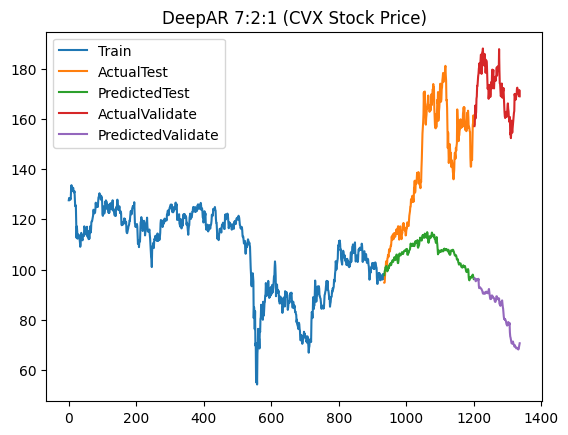

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 7:2:1 (CVX Stock Price)')
plt.show()

# Experiment: CVX 6-2-2

In [ ]:
df = pd.read_csv("/content/CVX.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,100.577354,5626000
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,101.310501,5805500
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,100.995163,4598300
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,100.829620,4189200
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,101.326271,4826100
...,...,...,...,...,...,...,...
1332,2023-04-19,169.460007,170.740005,169.100006,170.679993,169.024826,5506800
1333,2023-04-20,168.759995,170.059998,168.020004,169.850006,168.202881,5851100
1334,2023-04-21,169.830002,170.589996,168.839996,169.119995,167.479950,7179000
1335,2023-04-24,169.100006,172.380005,168.580002,171.479996,169.817062,7177600




> ***Devide train/test/validate 6/2/2***

In [ ]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
train_data
# #train: 802
# #test 267
# #val: 268

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,100.577354,5626000
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,101.310501,5805500
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,100.995163,4598300
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,100.829620,4189200
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,101.326271,4826100
...,...,...,...,...,...,...,...
797,2021-03-04,104.519997,107.580002,103.129997,104.500000,95.411827,22994200
798,2021-03-05,106.959999,109.129997,106.150002,109.000000,99.520477,23638200
799,2021-03-08,109.860001,110.430000,108.059998,109.750000,100.205261,18033600
800,2021-03-09,109.070000,110.690002,107.879997,109.500000,99.976997,19010700




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
train_ds = ListDataset(training_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([127.58, 128.51, 128.11, 127.9 , 128.53, 127.84, 128.66, 132.57,
         133.6 , 132.01, 132.36, 131.59, 131.3 , 132.56, 131.02, 131.39,
         130.65, 131.19, 128.48, 125.23, 125.35, 125.57, 118.58, 112.62,
         117.18, 115.29, 112.3 , 113.5 , 113.98, 113.29, 113.63, 112.53,
         112.14, 110.98, 109.06, 109.89, 112.59, 114.6 , 113.61, 111.92,
         112.04, 111.64, 113.15, 113.65, 113.84, 113.35, 117.22, 116.79,
         116.46, 115.13, 115.58, 115.4 , 113.89, 114.5 , 117.04, 113.7 ,
         112.98, 115.35, 114.66, 112.1 , 114.04, 112.24, 114.83, 114.48,
         117.29, 114.76, 115.98, 118.85, 119.25, 119.23, 119.92, 120.7 ,
         121.46, 123.82, 123.71, 122.31, 123.58, 122.54, 122.72, 124.22,
         126.62, 125.11, 124.86, 125.49, 126.01, 125.53, 124.94, 126.57,
         128.72, 128.82, 129.84, 130.39, 129.74, 129.56, 129.46, 127.86,
         129.37, 128.23, 128.7 , 126.61, 122.19, 121.39, 125.16, 124.3 ,
   



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=535,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:28<00:00,  1.74it/s, epoch=50/50, avg_epoch_loss=1.96]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

268

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267

In [ ]:
yval=val_data.Close.tolist()
len(yval)


268



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 23.89296348755794
Testing RMSE: 13.92532361151523
Validation MAPE: 12.29727222860651
Testing MAPE: 9.672596745369411
Validation MDA: 49.812734082397
Testing MDA: 57.14285714285714




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 535 days: [97.59197998046875, 98.26742553710938, 99.22531127929688, 99.21143341064453, 99.52922058105469, 98.7689437866211, 99.22308349609375, 98.11669158935547, 97.81456756591797, 98.73175811767578, 100.09595489501953, 100.56340789794922, 100.98477172851562, 100.51300048828125, 100.46788787841797, 100.26895141601562, 101.12297058105469, 101.77668762207031, 102.22230529785156, 101.52867126464844, 100.86474609375, 100.81281280517578, 100.64617919921875, 102.09114074707031, 102.51876831054688, 102.86187744140625, 102.59053039550781, 102.43317413330078, 102.02436828613281, 101.85054779052734, 103.01416778564453, 103.56037139892578, 103.73566436767578, 104.35559844970703, 104.42330169677734, 104.268798828125, 104.1319808959961, 105.20504760742188, 104.13348388671875, 103.08240509033203, 101.71692657470703, 101.5751724243164, 101.745849609375, 102.51305389404297, 103.36609649658203, 103.58355712890625, 103.41050720214844, 103.29025268554688, 103.22345733642578, 103.279



> Visualization



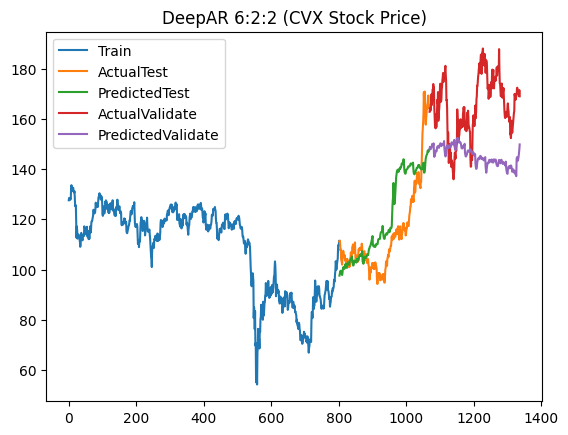

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 6:2:2 (CVX Stock Price)')
plt.show()

# Experiment: VLO 7-2-1

In [ ]:
df = pd.read_csv("/content/VLO.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400
...,...,...,...,...,...,...,...
1332,2023-04-19,125.959999,126.000000,122.199997,124.400002,123.259636,4409200
1333,2023-04-20,122.709999,123.300003,120.849998,122.949997,121.822929,3966600
1334,2023-04-21,122.440002,122.489998,118.680000,119.629997,118.533363,6644600
1335,2023-04-24,118.570000,121.389999,118.309998,120.000000,118.899971,5268600




> ***Devide train/test/validate 7/2/1***

In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
val_data
# #train: 935
# #test 267
# #val: 135

,Date,Open,High,Low,Close,Adj Close,Volume
1202,2022-10-11,109.489998,112.139999,108.080002,109.690002,107.145279,2874900
1203,2022-10-12,109.000000,116.419998,107.480003,115.199997,112.527451,4252300
1204,2022-10-13,113.419998,122.199997,112.940002,120.860001,118.056145,4495600
1205,2022-10-14,119.959999,121.800003,113.620003,114.120003,111.472511,3737800
1206,2022-10-17,116.500000,118.690002,115.339996,115.500000,112.820488,3712400
...,...,...,...,...,...,...,...
1332,2023-04-19,125.959999,126.000000,122.199997,124.400002,123.259636,4409200
1333,2023-04-20,122.709999,123.300003,120.849998,122.949997,121.822929,3966600
1334,2023-04-21,122.440002,122.489998,118.680000,119.629997,118.533363,6644600
1335,2023-04-24,118.570000,121.389999,118.309998,120.000000,118.899971,5268600




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
train_ds = ListDataset(training_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([ 92.8 ,  93.29,  93.59,  94.03,  94.22,  94.1 ,  94.15,  94.55,
          96.75,  96.15,  97.56,  96.46,  97.26,  98.95,  98.69,  97.66,
          97.18,  98.69,  96.39,  94.34,  95.97,  94.69,  93.19,  89.77,
          90.46,  89.84,  86.77,  88.22,  88.84,  89.48,  92.63,  93.  ,
          93.27,  91.58,  90.83,  92.05,  92.46,  93.31,  92.77,  90.42,
          90.82,  92.2 ,  91.56,  91.72,  92.04,  93.31,  94.32,  92.69,
          93.49,  92.66,  92.33,  93.79,  92.94,  94.47,  95.45,  93.04,
          91.22,  94.25,  92.27,  90.28,  92.77,  91.56,  92.7 ,  93.35,
          95.86,  95.18,  96.01,  98.89, 100.31, 100.53, 101.83, 105.49,
         106.69, 107.54, 108.2 , 108.55, 109.26, 108.29, 108.68, 111.54,
         109.78, 110.93, 110.72, 112.25, 113.37, 113.39, 113.67, 113.19,
         114.82, 114.49, 114.63, 115.87, 115.9 , 114.99, 119.71, 120.56,
         122.06, 120.15, 121.05, 121.88, 118.73, 119.47, 122.21, 121.2 ,
   



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=402,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:22<00:00,  2.21it/s, epoch=50/50, avg_epoch_loss=1.9]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

135

In [ ]:
yval=val_data.Close.tolist()
len(yval)


135

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 73.21521971042972
Testing RMSE: 45.75084619114782
Validation MAPE: 54.633111213261486
Testing MAPE: 44.759841191353736
Validation MDA: 46.26865671641791
Testing MDA: 52.255639097744364




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 402 days: [64.31725311279297, 64.07461547851562, 62.645137786865234, 62.41997528076172, 62.431976318359375, 62.408538818359375, 62.07789993286133, 59.225379943847656, 55.589786529541016, 53.705684661865234, 51.313472747802734, 50.175479888916016, 49.33735656738281, 47.93544006347656, 45.13471984863281, 43.416969299316406, 43.57878875732422, 42.98810577392578, 41.707427978515625, 41.203514099121094, 40.08869934082031, 38.52471160888672, 35.7943229675293, 35.091148376464844, 34.809146881103516, 34.89072799682617, 34.56495666503906, 34.74565124511719, 34.684207916259766, 34.115455627441406, 34.3769416809082, 35.158203125, 35.70170211791992, 36.29011917114258, 36.97803497314453, 37.65043258666992, 38.20356369018555, 38.492958068847656, 38.04729461669922, 38.161746978759766, 37.77995681762695, 37.87772750854492, 37.71086502075195, 37.75651931762695, 38.72917175292969, 38.984798431396484, 39.1052131652832, 39.42969512939453, 39.859561920166016, 40.05767822265625, 39.901



> Visualization



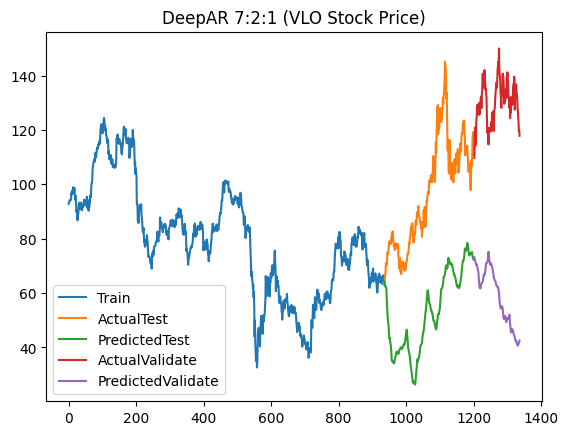

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 7:2:1 (VLO Stock Price)')
plt.show()

# Experiment: VLO 6-2-2

In [ ]:
df = pd.read_csv("/content/VLO.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400
...,...,...,...,...,...,...,...
1332,2023-04-19,125.959999,126.000000,122.199997,124.400002,123.259636,4409200
1333,2023-04-20,122.709999,123.300003,120.849998,122.949997,121.822929,3966600
1334,2023-04-21,122.440002,122.489998,118.680000,119.629997,118.533363,6644600
1335,2023-04-24,118.570000,121.389999,118.309998,120.000000,118.899971,5268600




> ***Devide train/test/validate 6/2/2***

In [ ]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
train_data
# #train: 802
# #test 267
# #val: 268

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400
...,...,...,...,...,...,...,...
797,2021-03-04,78.000000,78.610001,73.800003,76.370003,69.711533,6359300
798,2021-03-05,78.000000,79.059998,74.820000,79.029999,72.139610,4664400
799,2021-03-08,80.000000,82.599998,79.540001,80.559998,73.536224,4834600
800,2021-03-09,79.750000,81.339996,76.510002,76.580002,69.903229,5459600




> ***Modify input***



In [ ]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
train_ds = ListDataset(training_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([ 92.8 ,  93.29,  93.59,  94.03,  94.22,  94.1 ,  94.15,  94.55,
          96.75,  96.15,  97.56,  96.46,  97.26,  98.95,  98.69,  97.66,
          97.18,  98.69,  96.39,  94.34,  95.97,  94.69,  93.19,  89.77,
          90.46,  89.84,  86.77,  88.22,  88.84,  89.48,  92.63,  93.  ,
          93.27,  91.58,  90.83,  92.05,  92.46,  93.31,  92.77,  90.42,
          90.82,  92.2 ,  91.56,  91.72,  92.04,  93.31,  94.32,  92.69,
          93.49,  92.66,  92.33,  93.79,  92.94,  94.47,  95.45,  93.04,
          91.22,  94.25,  92.27,  90.28,  92.77,  91.56,  92.7 ,  93.35,
          95.86,  95.18,  96.01,  98.89, 100.31, 100.53, 101.83, 105.49,
         106.69, 107.54, 108.2 , 108.55, 109.26, 108.29, 108.68, 111.54,
         109.78, 110.93, 110.72, 112.25, 113.37, 113.39, 113.67, 113.19,
         114.82, 114.49, 114.63, 115.87, 115.9 , 114.99, 119.71, 120.56,
         122.06, 120.15, 121.05, 121.88, 118.73, 119.47, 122.21, 121.2 ,
   



> ***Train model***



In [ ]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=535,
    context_length=60,
    trainer=Trainer(ctx="cpu", epochs=50),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[1],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:28<00:00,  1.77it/s, epoch=50/50, avg_epoch_loss=1.91]




> ***Apply model for test and validate dataset***



In [ ]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [ ]:
y_pred = forecast[:267]
y_pred_val = forecast[267:]

len(y_pred_val)

268

In [ ]:
ytest=test_data.Close.tolist()
len(ytest)

267

In [ ]:
yval=val_data.Close.tolist()
len(yval)


268



> ***Evaluate model***



In [ ]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    squared_errors = [(a - b) ** 2 for a, b in zip(list1, list2)]
    mean_squared_error = sum(squared_errors) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse

def calculate_mape(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    errors = []
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error = abs((y_true[i] - y_pred[i]) / y_true[i])
            errors.append(error)

    mape = sum(errors) / len(errors) * 100
    return mape

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Lists must have the same length")

    num_correct = 0
    for i in range(1, len(y_true)):
        if (y_true[i] - y_true[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            num_correct += 1

    mda = num_correct / (len(y_true) - 1) *100
    return mda

test_rmse = calculate_rmse(ytest, y_pred)
valid_rmse = calculate_rmse(yval, y_pred_val)

test_mape = calculate_mape(ytest, y_pred)
valid_mape = calculate_mape(yval, y_pred_val)

test_mda = calculate_mda(ytest, y_pred)
valid_mda = calculate_mda(yval, y_pred_val)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 56.47311272081928
Testing RMSE: 14.960085929662258
Validation MAPE: 44.16373657604441
Testing MAPE: 16.33070636466494
Validation MDA: 46.06741573033708
Testing MDA: 46.99248120300752




> ***Show result***



In [ ]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 535 days: [65.18541717529297, 65.53185272216797, 63.92619323730469, 62.73175811767578, 62.51472091674805, 62.879573822021484, 63.274330139160156, 60.219459533691406, 58.964752197265625, 57.483341217041016, 56.65599060058594, 55.718467712402344, 55.192264556884766, 53.86997604370117, 52.729698181152344, 52.29494094848633, 52.675140380859375, 52.430908203125, 52.43544006347656, 52.53962707519531, 52.53841781616211, 52.454193115234375, 52.370697021484375, 52.61867141723633, 52.357364654541016, 52.726829528808594, 53.078453063964844, 53.55683135986328, 53.970706939697266, 55.01292037963867, 54.831809997558594, 55.35103988647461, 56.115440368652344, 56.846500396728516, 57.69027328491211, 59.40650939941406, 61.194618225097656, 60.913856506347656, 59.360084533691406, 57.668514251708984, 56.948036193847656, 56.96623229980469, 57.602333068847656, 58.553619384765625, 60.09108352661133, 61.0599479675293, 61.46065902709961, 61.4185791015625, 61.663448333740234, 61.62485885620



> Visualization



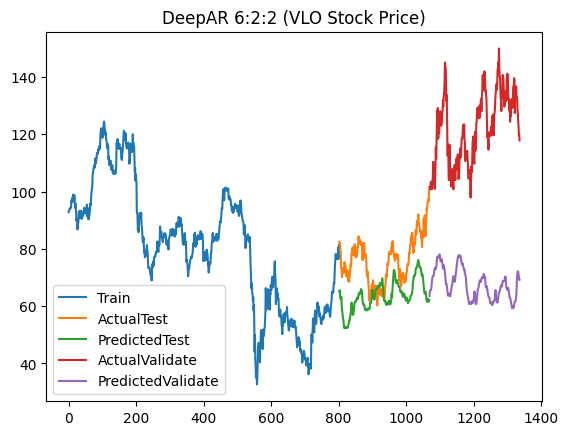

In [ ]:
# 14.Vẽ hình
train_value=train_data.Close.tolist()
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,(train_value))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,ytest)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,yval)
val_pre_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate'])
plt.title('DeepAR 6:2:2 (VLO Stock Price)')
plt.show()